# Integrated Energy Systems: Nuclear Case Study using TEAL Cash Flows and RAVEN Synthetic Histories

In this notebook, we formulate a multi-period optimization problem that determines the optimal design of an integrated energy system producing electricity and hydrogen such that its net present value (NPV) is maximized for a given market signal. We consider an **existing** nuclear power plant of 1000 MW capcity as the genator. In general, due to safety restrictions, nuclear power plants are not amenable for ramping. Therefore, we assume that the power plant always operates at its base load (i.e., 1000 MW). We are interested in determining whether the following options are attractive (i.e., maximize NPV):

- Produce hydrogen using a portion of the electricity, especially during periods of low electricity demand, and sell it.
- Produce hydrogen, store it in a tank, and combust it to produce electrity during the periods of high electricity demand.

Towards this, we formulate the superstructure shown in the figure below.

![](schematic_nuclear_flowsheet.png "Nuclear Flowsheet")

In the figure, arrows in red and blue denote that electricity and material, respectively, flows through them. ID denotes the name of the object containing the corresponding unit's model in the code, and DD and OD stand for design decision and operating decision, respectively.  

Here, we use a PEM (polymer electrolyte membrane) electrolyzer to produce hydrogen via water electrolysis. Current PEM technology requires ~54 kWh/kg of hydrogen (see https://www.h-tec.com/en/products/detail/h-tec-pem-electrolyser-me100-350/me100-350/ , last accessed on February 18, 2022). The produced hydrogen is stored in a tank, which can either be sold to the market via a pipeline, or combusted in a hydrogen turbine to produce electricity during the periods of high demand for electricity. Note that

- The hydrogen tank is modeled as a simple inventory model i.e., only mass balance is enforced. The enthalpy balance is not included in the model. If needed, the `SimplifiedHydrogenTank` model in the flowsheet can be replaced with a more detailed tank model (the DISPATCHES repository has a more detailed tank model that enforces enthalpy balance as well).
- The hydrogen turbine is modeled as a compressor, a stochiometric reactor, and a turbine connected in series. 

In the flowsheet model, we use two different thermodynamic packages: one for the PEM electrolyzer and the hydrogen tank, and the other for the mixer and the hydrogen turbine. This is because, the material stream(s) to and from the former units only contain hydrogen. Whereas, the material stream(s) to and from the latter units contain nitrogen, oxygen, water and argon, in addition to hydrogen. The translator block facilitates the use of multiple thermodynamic packages by connecting properties across the packages. 

### Objective
For a given market signal, our objective is to determine the optimal design decisions,

- Size of the PEM electrolyzer (`pem_capacity`: maximum rated capacity of the PEM electrolyzer, in MW)
- Size of the hydrogen tank (`tank_capacity`: maximum amount of hydrogen that can be stored in the tank, in kg)
- Size of the hydrogen turbine (`turbine_capacity`: maximum power the hydrogen turbine can produce, in MW)

and the optimal operating decisions,

- Split fraction of electricity to the pem electrolyzer (`m.fs.np_power_split.split_fraction["np_to_pem", 0]`)
- Molar flowrate of hydrogen to the pipeline (`m.fs.h2_tank.outlet_to_pipeline.flow_mol[0]`)
- Molar flowrate of hydrogen to the turbine (`m.fs.h2_tank.outlet_to_turbine.flow_mol[0]`)

which maximize the NPV.

### RAVEN and TEAL Installation
The Tool for Economic Analysis (TEAL) Python software is a plugin for the Risk Analysis Virtual Environment (RAVEN) and developed at Idaho National Lab (INL). TEAL is aimed to contain and deploy complex economic analyses. It allows for a generic definition of cash flows, flexible options to deal with taxes, inflation, discounting, and offers capabilities to compute combined cashflows for components. It also enables the ability to compute different economic metrics: Net Present Value (NPV), Internal Rate of Return (IRR), and Profitability Index (PI). More information on TEAL can be found at https://github.com/idaholab/TEAL. 

To run TEAL, first the user must build and install the RAVEN software package on their machine. Installation instructions for Mac, Linux, and Windows can be found here: https://github.com/idaholab/raven/wiki/installationMain. This will create a Python environment with all RAVEN and TEAL dependencies installed. 

To install TEAL, follow the instructions here: https://github.com/idaholab/raven/wiki/Plugins#registration-and-installation. 

Once RAVEN and TEAL are installed, the easiest way to integrate TEAL with DISPATCHES is to pip install DISPATCHES and all dependencies within the RAVEN Python environment (there will be future work in getting RAVEN installed as its own pip install-able package). First, activate the RAVEN environment (here referred to as ``raven_libraries``) and then install DISPATCHES as follows:

```bash
  # activate existing RAVEN python environment using conda
  cd raven
  conda activate raven_libraries

  # load raven libraries (if on Windows and using Anaconda Prompt, run 'conda install m2-base' to get sh command)
  sh ./scripts/establish_conda_env.sh --load

  # here, assuming that DISPATCHES and RAVEN are in same directory
  cd ../dispatches 

  # usually got an SSL certificate error, fix is to add github to trusted hosts
  python -m pip install -r requirements-dev.txt --trusted-host=codeload.github.com
```

Next, we import the required packages and functions needed for the formulation of the optimization problem.

In [1]:
# General python imports
import os
import json
import logging
import numpy as np

# Pyomo imports
from pyomo.environ import (
    ConcreteModel,
    RangeSet,
    Var,
    NonNegativeReals,
    Constraint,
    Expression,
    Objective,
    value,
    maximize,
    units as pyunits,
)

# IDAES imports
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.apps.grid_integration import MultiPeriodModel

# Nuclear flowsheet function imports
from dispatches.case_studies.nuclear_case.nuclear_flowsheet import (
    build_ne_flowsheet,
    fix_dof_and_initialize,
)

from dispatches.case_studies.nuclear_case.TEAL_integration import (
    build_econ_settings,
    build_TEAL_Component,
    calculate_TEAL_metrics,
)

from dispatches.case_studies.nuclear_case.SynHist_integration import SynHist_integration

PluginFactory: No installed plugins detected.


PySide2/__init__.py: Unable to import shiboken2 from c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\ray\thirdparty_files, c:\Users\Radhakrishna\Desktop\code_repositories\dispatches\dispatches\case_studies\nuclear_case, c:\Users\Radhakrishna\.conda\envs\teal-int-test\python38.zip, c:\Users\Radhakrishna\.conda\envs\teal-int-test\DLLs, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib, c:\Users\Radhakrishna\.conda\envs\teal-int-test, , c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages, c:\users\radhakrishna\desktop\code_repositories\dispatches, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\win32, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\win32\lib, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\Pythonwin, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\IPython\extensions, C:\Users\Radhakrishna\.ipython, c:\Users\Radhakrishna\.conda\envs\teal-int-test\lib\site-packages\PySA

## Simulation of the Flowsheet

Before we formulate the multiperiod optimization problem, we first simulate the nuclear flowsheet and print some results. This helps the reader to familiarize themselves with the names, along with their default units, of a few important variables. The readers are encouraged to go through the `nuclear_flowsheet.py` script. It contains the function `build_ne_flowsheet` which assembles models for all the units in the flowsheet, and connects them via `Arc` objects. It also contains the function `fix_dof_and_initialize` which fixes the degrees of freedom and initializes the entire flowsheet.

The flowsheet has four degrees of freedom viz.,

- Split fraction of electricity to the grid in the power splitter (variable `m.fs.np_power_split.split_fraction["np_to_grid", 0]` in the model). We fix this variable to 0.8.
- Molar flowrate of hydrogen to the pipeline (variable `m.fs.h2_tank.outlet_to_pipeline.flow_mol[0]`). We fix this variable to 10 mol/s.
- Molar flowrate of hydrogen to the turbine (variable `m.fs.h2_tank.outlet_to_turbine.flow_mol[0]`). We fix this variable to 10 mol/s.
- Initial holdup of hydrogen in the tank (variable `m.fs.h2_tank.tank_holdup_previous[0]`). We fix this variable to 0 mol.

These variables are fixed in the `fix_dof_and_initialize` function. In addition to the above three variables, we also fix the variables shown in the table below. We do not refer these variables as degrees of freedom, because they remain fixed at these values in the multiperiod optimization model.

| Name | Variable | Value |
| :- | :- | :-: |
| Pressure difference across `h2_turbine`'s compressor | `m.fs.h2_turbine.compressor.deltaP` | 24.01 bar |
| Isentropic efficiency of `h2_turbine`'s compressor   | `m.fs.h2_turbine.compressor.efficiency_isentropic` | 0.86 |
| Conversion of hydrogen in `h2_turbine`'s reactor     | `m.fs.h2_turbine.stoic_reactor.conversion`         | 0.99 |
| Pressure deifference across `h2_turbine`'s turbine   | `m.fs.h2_turbine.turbine.deltaP` | -24.01 bar |
| Isentripic efficiency of `h2_turbine`'s turbine      | `m.fs.h2_turbine.turbine.efficiency_isentropic`  | 0.89 |
| Molar flow rate of air to `h2_turbine`               | `m.fs.mixer.air_feed.flow_mol[0]`  | 10.76 * molar flowrate of hydrogen to turbine |
| Temperature of air | `m.fs.mixer.air_feed.temperature[0]` | 300 K |
| Pressure of air |  `m.fs.mixer.air_feed_pressure[0]`  | 1.01325 bar |
| Duration of the simulation for `h2_tank` | `m.fs.h2_tank.dt`  | 3600 s |


In [2]:
# Build the nuclear flowsheet with the capacity of the power plant as 1000 MW
m = build_ne_flowsheet(np_capacity=1000)

# Fix the degrees of freedom and initialize
fix_dof_and_initialize(
    m,
    split_frac_grid=0.8,
    tank_holdup_previous=0,
    flow_mol_to_pipeline=10,
    flow_mol_to_turbine=10,
)

# Ensure that the resulting model is a square problem i.e., its degrees of freedom must be 0
print("Degrees of freedom: ", degrees_of_freedom(m))
assert degrees_of_freedom(m) == 0

# Create a solver object with the default solver (IPOPT)
solver = get_solver()

# Simulate the entire flowsheet
solver.solve(m, tee=True)

2023-02-03 17:30:38 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
Degrees of freedom:  0
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material result

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 215, 'Number of variables': 215, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.17031359672546387}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Verify that IPOPT converges to the optimal solution. Next, we print some results. Note the names of the variables and their default units (we use Pyomo's `units`, imported as `pyunits`, to obtain the units of a variable). Units are needed to correctly define the cash flow expressions later.

In [3]:
def get_units(obj):
    return str(pyunits.get_units(obj))

# Print results: power splitter
print("Nuclear plant power production : ", m.fs.np_power_split.electricity[0].value,
      get_units(m.fs.np_power_split.electricity[0]))
print("Electricity to grid            : ", m.fs.np_power_split.np_to_grid_port.electricity[0].value,
      get_units(m.fs.np_power_split.np_to_grid_port.electricity[0]))
print("Electricity to PEM             : ", m.fs.np_power_split.np_to_pem_port.electricity[0].value,
      get_units(m.fs.np_power_split.np_to_pem_port.electricity[0]))
print()

# Print results: PEM electrolyzer
print("Flowrate of H2 from pem        : ", m.fs.pem.outlet.flow_mol[0].value,
      get_units(m.fs.pem.outlet.flow_mol[0]))
print()

# Print results: Hydrogen tank
print("Flowrate of H2 to tank         : ", m.fs.h2_tank.inlet.flow_mol[0].value,
      get_units(m.fs.h2_tank.inlet.flow_mol[0]))
print("Flowrate of H2 to pipeline     : ", m.fs.h2_tank.outlet_to_pipeline.flow_mol[0].value,
      get_units(m.fs.h2_tank.outlet_to_pipeline.flow_mol[0]))
print("Flowrate of H2 to turbine      : ", m.fs.h2_tank.outlet_to_turbine.flow_mol[0].value,
      get_units(m.fs.h2_tank.outlet_to_turbine.flow_mol[0]))
print("Initial tank holdup            : ", m.fs.h2_tank.tank_holdup_previous[0].value,
      get_units(m.fs.h2_tank.tank_holdup_previous[0]))
print("Tank holdup at the end of 1 hr : ", m.fs.h2_tank.tank_holdup[0].value,
      get_units(m.fs.h2_tank.tank_holdup[0]))

# Print results: Hydrogen Turbine
print("H2 Turbine's compressor work   : ", m.fs.h2_turbine.compressor.work_mechanical[0].value,
      get_units(m.fs.h2_turbine.compressor.work_mechanical[0]))
print("H2 Turbine's turbine work      : ", m.fs.h2_turbine.turbine.work_mechanical[0].value,
      get_units(m.fs.h2_turbine.turbine.work_mechanical[0]))
print("Net power produced by turbine  : ", -value(m.fs.h2_turbine.work_mechanical[0]),
      get_units(m.fs.h2_turbine.work_mechanical[0]))

Nuclear plant power production :  1000000.0 kW
Electricity to grid            :  800000.0 kW
Electricity to PEM             :  200000.0 kW

Flowrate of H2 from pem        :  505.48119999999994 mol/s

Flowrate of H2 to tank         :  505.48119999999994 mol/s
Flowrate of H2 to pipeline     :  10 mol/s
Flowrate of H2 to turbine      :  10 mol/s
Initial tank holdup            :  0 mol
Tank holdup at the end of 1 hr :  1747732.3199999998 mol
H2 Turbine's compressor work   :  1764604.5955977982 kg*m**2/s**3
H2 Turbine's turbine work      :  -2672169.1262004385 kg*m**2/s**3
Net power produced by turbine  :  907564.5306026402 kg*m**2/s**3


Observe that the power variables in the power splitter model and the PEM electrolyzer model use kW. Whereas, the power variables (mechanical work) use in the hydrogen turbine model use W. This complete the simulation of the flowsheet. Before proceeding further, we delete the object `m` to avoid confusion

In [4]:
# Delete the object containing the flowsheet
del m

## Multiperiod Optimization Model: Deterministic

Now, we formulate the multi-period price-taker problem to determine the optimal design and operating decisions maximizing the NPV. The optimization problem is of the form
$$ \begin{aligned}
\max_{D, u_{t, d}} \quad & \text{NPV}(D, u_{t, d})\\
& g(u_{t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}  \\
& h(u_{t, d}) \le 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}  \\
& f(u_{t-1,d}, u_{t,d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C} \\
& u_{t,d} \le D, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}
\end{aligned}$$

Here, the sets $\mathcal{T} = \{1, \dots, 24\}$ and $\mathcal{C} = \{1, \dots, 20\}$ denote the set of hours in a day and the set of clusters/days in a year, respectively. $D$ denotes the design decisions (or, first-stage variables) viz. size of the PEM electrolyzer (`pem_capacity`), tank (`tank_capacity`) and the turbine (`turbine_capacity`). $u_{t, d}$ denotes the operating decisions (or, second-stage decisions) at time $t$ of day/cluster $d$. $g(u_{t, d}) = 0$ and $h(u_{t,d}) \le 0$ denote the flowsheet model, $f(u_{t-1,d}, u_{t,d}) = 0$ connects the operating decisions at time $t-1$ and at time $t$ (e.g., tank holdup), and $u_{t,d} \le D$ ensures that the operating decision values never exceed the design capacity values (e.g., tank holdup at any time instant must not exceed the tank capacity).

### LMP Signal
Our objective is to determine the optimal size of the PEM, tank and turbine maximizing the NPV for a given 'market signal'. Throughout the notebook, by market signal or price signal, we refer to the locational marginal price (LMP) (selling price of electricity, in $/MWh) as a function of time. The LMP depends on several factors such as weather, demand, generator mix of the grid, and so forth. Owing to the uncertain nature of some those factors, it is not possible to predict the exact value of the LMP way into the future. Nevertheless, in this section, we **assume that the LMP signal is accurate** (i.e., there is no uncertainty in the price). Later, we show how the same framework/workflow can be used to easily formulate a stochastic program to handle the uncertainty in the price signal. 

### Sampling from a Trained ARMA Model
In previous notebooks, LMP data was taken from a file called `lmp_signal.json`. That dataset was generated using the FORCE toolset provided by Idaho National Lab. In particular, RAVEN (https://github.com/idaholab/raven) was used to train an auto-regressive moving average (ARMA) model based on price data from 2019/2020 New York Independent System Operator (NYISO). The JSON file contained several sampled scenarios (or synthetic histories) generated from that ARMA model.

Here, we allow the user to sample from any trained ARMA model from RAVEN. An ARMA model is provided as an example in the ```\ARMA_Model``` subdirectory, please note that this model is meant for demonstration only (no meaningful conclusions should be made from simulation results). 
RAVEN divides the 365 days of a year into a specified number of clusters (20, in our case), and generates the LMP signal for each cluster (Note that the LMP signal is the same for all the days of a cluster). The figure below plots the LMP signal for cluster 1 (left) and cluster 8.

![](sample_lmp_plots.png)

As evident from the figure, the price can vary significantly in a day, and from cluster to cluster. Given the variation, we are interested in determining if producing hydrogen, especially during the periods when LMP is low, is attractive or not. 

Also note that ARMA models occasionally go through minor structural changes; be sure to update RAVEN and retrain the ARMA model when such changes are implemented. Details and workshop examples on how to train an ARMA model can be found at: https://github.com/idaholab/raven/tree/devel/doc/workshop/ARMA. 


### Years Used in Demonstration
Previously, we did not use the entire dataset in `lmp_signal.json`. Instead, we used the LMP signal only for the years 2022 and 2032. We assume that the plant lifetime is twenty years. We used the 2022 LMP signal for the first ten years (i.e., 2022 - 2031), and the 2032 LMP signal for the next ten years (i.e., 2032 - 2041).

Now, we use the plant lifetime and a starting year (based on available years within the ARMA model) to extract synthetic LMP histories for all corresponding years. E.g., for starting year 2020 and plant lifetime of 20 years, we generate histories for 2020 - 2040. Please note that computation time will increase with requested number of years. 

In [5]:
# Define Time sets
plant_life = 5
startYear  = 2020
set_years = range(startYear, startYear + plant_life)  # Set of years

# location of trained ARMA model file
cwd = os.getcwd()
targetFile = cwd + "\\ARMA_Model\\arma.pk"
synHistIntegration = SynHist_integration(targetFile) # this object used to generate histories

# generate single synthetic history / sampled scenario
synHistDict = synHistIntegration.generateSyntheticHistory("price", set_years)

# LMP Signal
LMP = synHistDict["LMP"]
weights_days = synHistDict["weights_days"]

InputData: Using param spec "pickledROM" to read XML node "ROM.
(13661.99 sec) Interp. Cluster ROM      : DEBUG           -> Evaluating interpolated ROM ...
(13662.00 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2018" (1 / 28)
(13662.50 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2019" (2 / 28)
(13662.52 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2020" (3 / 28)
(13662.53 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2021" (4 / 28)
(13662.56 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2022" (5 / 28)
(13662.58 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2023" (6 / 28)
(13662.60 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2024" (7 / 28)
(13662.63 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2025" (8 / 28)
(13662.65 s

We use the `MultiPeriodModel` class in IDAES to formulate the multi-period optimization problem and specify the following arguments
- `n_time_points`: Number of elements in $\mathcal{T}$
- `set_days`: The set of clusters/representative days
- `set_years`: The set of years
- `process_model_func`: Function that builds an instance of the process flowsheet
- `initialization_func`: Function that initializes an instance of the process flowsheet
- `unfix_dof_func`: Function that unfixes a degrees of freedom for optimization
- `linking_variable_func`: Function that yields pairs of variables that are connected across two consecutive time periods
- `flowsheet_options`: Dictionary containing arguments required for `process_model_func`
- `initialization_options`: Dictionary containing arguments required for `initialization_func`
- `use_stochastic_build`: If True, uses the generalized method, `build_stochastic_multi_period`, for formulating the multi-period problem.
- `outlvl`: Output level

For our problem, `n_time_points=24`,`set_days=[1, 2, ..., 20]`, `set_years=[2022, 2032]`, `process_model_func=build_ne_flowsheet`, `initialization_func=fix_dof_and_initialize`. We now construct two functions, `unfix_dof` and `get_linking_variable_pairs`, for `unfix_dof` and `linking_variable_func` arguments.

`unfix_dof` unfixes a few degrees of freedom for optimization. In particular, it 
- Unfixes the split fractions of the power splitter. The optimizer then determines the optimal split fraction of the electricity to the grid, and to the PEM electrolyzer.
- Unfixes the initial tank holdup. The initial tank holdup is governed by the final tank holdup at the previous hour.
- Unfixes the molar flow rate of hydrogen to the turbine and to the pipeline.
- Unfixes the molar flow rate of air to the turbine.
- Adds a constraint to fix the ratio of molar flow rate of air to molar flowrate of hydrogen (fuel-air ratio).
- Specifies a small non-zero bounds on a few flow variables to avoid convergence issues.

In [6]:
def unfix_dof(m, air_h2_ratio=10.76):
    """
    This function unfixes a few degrees of freedom for optimization
    """
    # Unfix the electricity split in the electrical splitter
    m.fs.np_power_split.split_fraction["np_to_grid", 0].unfix()

    # Unfix the holdup_previous and outflow variables
    m.fs.h2_tank.tank_holdup_previous.unfix()
    m.fs.h2_tank.outlet_to_turbine.flow_mol.unfix()
    m.fs.h2_tank.outlet_to_pipeline.flow_mol.unfix()

    # Unfix the flowrate of air to the mixer
    m.fs.mixer.air_feed.flow_mol.unfix()

    # Add a constraint to maintain the air to hydrogen flow ratio
    m.fs.mixer.air_h2_ratio = Constraint(
        expr=m.fs.mixer.air_feed.flow_mol[0] ==
             air_h2_ratio * m.fs.mixer.hydrogen_feed.flow_mol[0])
    
    # Set bounds on variables. A small non-zero value is set as the lower 
    # bound on molar flowrates to avoid convergence issues
    m.fs.pem.outlet.flow_mol[0].setlb(0.001)

    m.fs.h2_tank.inlet.flow_mol[0].setlb(0.001)
    m.fs.h2_tank.outlet_to_turbine.flow_mol[0].setlb(0.001)
    m.fs.h2_tank.outlet_to_pipeline.flow_mol[0].setlb(0.001)

    m.fs.translator.inlet.flow_mol[0].setlb(0.001)
    m.fs.translator.outlet.flow_mol[0].setlb(0.001)

    m.fs.mixer.hydrogen_feed.flow_mol[0].setlb(0.001)

In [7]:
def get_linking_variable_pairs(ct, ft):
    """Yield pairs of variables that need to be connected across time periods.

    The only variable that is connected across two time periods is the tank holdup.

    Args:
        ct: current time step
        ft: the next time step
    """
    return [(ct.fs.h2_tank.tank_holdup[0], ft.fs.h2_tank.tank_holdup_previous[0])]

In [8]:
def add_capacity_variables(m):
    
    """
    This function declares the first-stage variables or design decisions, and
    adds constraints that ensure that the operational variables never exceed their
    design values.
    """
    if hasattr(m, "set_period"):
        set_period = m.set_period
    else:
        set_period = m.parent_block().set_period

    # Declare first-stage variables (Design decisions)
    m.pem_capacity = Var(
        within=NonNegativeReals,
        doc="Maximum capacity of the PEM electrolyzer (in kW)",
        units=pyunits.kW,
    )
    m.tank_capacity = Var(
        within=NonNegativeReals,
        doc="Maximum holdup of the tank (in mol)",
        units=pyunits.mol,
    )
    m.h2_turbine_capacity = Var(
        within=NonNegativeReals,
        doc="Maximum power output from the turbine (in W)",
        units=pyunits.W,
    )

    m.pem_capacity_constraint = Constraint(set_period)
    m.tank_capacity_constraint = Constraint(set_period)
    m.turbine_capacity_constraint = Constraint(set_period)

    for t in set_period:
        # Ensure that the electricity to the PEM elctrolyzer does not exceed the PEM capacity
        m.pem_capacity_constraint.add(
            t, m.period[t].fs.pem.electricity[0] <= m.pem_capacity
        )
        # Ensure that the final tank holdup does not exceed the tank capacity
        m.tank_capacity_constraint.add(
            t, m.period[t].fs.h2_tank.tank_holdup[0] <= m.tank_capacity
        )
        # Ensure that the power generated by the turbine does not exceed the turbine capacity
        m.turbine_capacity_constraint.add(
            t, - m.period[t].fs.h2_turbine.work_mechanical[0] <= m.h2_turbine_capacity
        )

Next, we use the `MultiPeriodModel` class to build the constraints $g(u_{t,d}) = 0$ and $h(u_{t,d}) \le 0$ $\forall \; t \in \mathcal{T}$ and $\forall \; d \in \mathcal{C}$. It creates an instance of the flowsheet (using the `build_ne_flowsheet` function) for each time instance, fixes its degrees of freedom and initializes it (using the `fix_dof_and_initialize` function), unfixes operational degrees of freedom (using the `unfix_dof` function), and adds constraints of the form $f(u_{t-1,d}, u_{t,d}) = 0$ (using the `get_linking_variable_pairs` functions). Then, we add the capacity constraints of the form $u_{t,d} \le D$ using `add_capacity_variables` function. 

<div class="alert alert-block alert-info">
<b>Tip:</b>
Building the multiperiod model can take some time. To monitor the progress, set `outlvl=logging.INFO`
</div>

In [9]:
set_years = list(set_years)                                # Set of years
set_days = list(LMP[set_years[0]].keys())                  # e.g., twenty clusters/days per year
n_time_points = len(LMP[set_years[0]][set_days[0]].keys()) # e.g., twenty fours in a day

# Formulate the multiperiod optimization problem
m = MultiPeriodModel(
    n_time_points=n_time_points,
    set_days=set_days,
    set_years=set_years,
    process_model_func=build_ne_flowsheet,
    initialization_func=fix_dof_and_initialize,
    unfix_dof_func=unfix_dof,
    linking_variable_func=get_linking_variable_pairs,
    flowsheet_options={"np_capacity": 1000},
    initialization_options={
        "split_frac_grid": 0.8,
        "tank_holdup_previous": 0,
        "flow_mol_to_pipeline": 10,
        "flow_mol_to_turbine": 10,
    },
    use_stochastic_build=True,
    outlvl=logging.WARNING,
)

# Add first-stage variables 
add_capacity_variables(m)

[+   0.00] Beginning the formulation of the multiperiod optimization problem.
[+ 500.98] Completed the formulation of the multiperiod optimization problem.
2023-02-03 17:39:09 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
[+   7.07] Created an instance of the flowsheet and initialized it.
[+  38.23] Initialized the entire multiperiod optimization model.
[+   1.16] Unfixed the degrees of freedom from each period model.


Next, we fix initial tank holdup at the beginning of each day, and set an upper bound on the amount of hydrogen than can be sold to the market.

In [10]:
# Define parameters
m.plant_life = plant_life                    # Plant lifetime: 20 years
m.tax_rate = 0.2                             # Corporate tax rate: 20%
m.discount_rate = 0.08                       # Discount rate: 8%
m.h2_demand = 1                              # Maximum amount of hydrogen that can be sold: 1 kg/s

m.LMP = LMP
m.weights_days = weights_days
MW_H2 = 2.016e-3

# Set initial holdup for each day (Assumed to be zero at the beginning of each day)
for y in m.set_years:
    for d in m.set_days:
        m.period[1, d, y].fs.h2_tank.tank_holdup_previous.fix(0)

# Hydrogen demand constraint. divide the RHS by the molecular mass to convert kg/s to mol/s
@m.Constraint(m.set_period)
def hydrogen_demand_constraint(blk, t, d, y):
    return blk.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0] <= m.h2_demand / MW_H2

## Cash Flow Values

We use the numbers in the table below for constructing the cash flow expressions.

| Unit | CAPEX | Fixed O&M | Variable O&M |
| :- | :-: | :-: | :-: |
| PEM Electrolyzer | \$1630 /kW | \$47.9 /kW | \$1.3 /MWh |
| Hydrogen tank | \$29 /kWh  |  0 |  0 |
| Hydrogen turbine | \$947 /kW  | \$7 /kW | \$4.25 /Mwh|

We refer the reader to the Simulation of the Flowsheet section for the default units of the decision variables. We convert the cost numbers so that the units are consistent with that of the variable.

## Define TEAL Component Cash Flows

We now add a template dictionary with all the Nuclear Case components. 
Each plant component has nested dictionaries for each desired TEAL cash flow. 
Note that all cash flows are defined as:
  $$C_y = m \alpha_y \bigg(\frac{D_y}{D^{\prime}}\bigg)^X$$
The cash flow $C_y$ is indexed by year, but hourly indeces can also be created and summed per year. Other parameters include $\alpha$, the reference price, $D_y$ the driver for the cash flow (e.g., number of units sold, hours of electricity produced, etc.), $D^{\prime}$ the reference driver corresponding to $\alpha$ (optional), $X$ the scaling factor, and $m$ an extra multiplier.


The cash flow dictionaries below must have:
1. an **Expression**: a list of strings of the Pyomo variable name used as the cash flow driver ($D_y$)
2. a **Value**: the cost per unit ($\alpha$)
3. a **Multiplier**: an extra multiplier to distinguish between +/- cash flows ($m$)

Each component must also have a Lifetime but all currently set to be the same. The TEAL-DISPATCHES integration currently does not support scaling factors. 
**NOTE**: All expressions currently correspond to 

In [11]:
components={
  # Electrolyzer: negative Cash flows
  "pem":{ 
    "Lifetime": 20,
    "Capex":{
        "Expressions": ['pem_capacity'],
        "Value": 1630, # $/kW
        "Multiplier": [-1],
        "Amortization":15,
    },
    "FixedOM":{
      "Expressions": ['pem_capacity'],
      "Value": 47.9, # $/kW
      "Multiplier": [-1],
    },
    "Hourly":{
      "Expressions": ['fs.pem.electricity'],
      "Value": 1.3e-3, # $/MWh -> $/kWh
      "Multiplier": [-1],
    },
  },
  # Hydrogen Tank: negative Cash flows
  "h2tank":{
    "Lifetime": 20,
    "Capex":{
      "Expressions": ['tank_capacity'],
      "Value": 1.946851199, # $29/kWh * 33.3 kWh/kg * 2.016e-3 kg/mol
      "Multiplier": [-1],
      "Amortization":15,
    },
  },
  # Hydrogen Turbine: negative Cash flows
  "h2turbine":{ 
    "Lifetime": 20,
    "Capex":{
      "Expressions": ['h2_turbine_capacity'],
      "Value": 0.947, # $/kW -> $/W
      "Multiplier": [-1],
      "Amortization":15,
    },
    "FixedOM":{
      "Expressions": ['h2_turbine_capacity'],
      "Value": 0.007, # $/kW -> $/W
      "Multiplier": [-1],
    },
    "Hourly":{
      "Expressions": ['fs.h2_turbine.turbine.work_mechanical',
        'fs.h2_turbine.compressor.work_mechanical'],
      "Value": 4.25e-6, # $/MWh -> $/Wh
      "Multiplier": [1, 1], # these values come out with correct sign in expression
    },
  },
  # Electricity Market: positive Cash flows
  "electricity_market":{
    "Lifetime": 20,
    "Hourly":{
      "Expressions": ['fs.np_power_split.np_to_grid_port.electricity',
        'fs.h2_turbine.turbine.work_mechanical',
        'fs.h2_turbine.compressor.work_mechanical'],
      "Value": [], # this is LMP in $/MWh, should be path str to ROM
      "Multiplier": [1e-3, -1e-6, -1e-6], # converting to $/kWh and $/Wh
    },
  },
  # Hydrogen Market: positive Cash flows
  "h2_market":{
    "Lifetime": 20,
    "Hourly":{
      "Expressions": ['fs.h2_tank.outlet_to_pipeline.flow_mol'], # this is in mol/s
      "Value": 6.0, # this is $/kg, NOTE: this is increased from previous $3/kg
      "Multiplier":  [7.2576] # convert from $/kg -> $/mol and also converting mol/s to mol/hr
    },
  },
}

Next, we initialize global Cash flow attributes within TEAL.

This includes passing discount rates, plant life, etc. from the notebook to an object of TEAL global parameters. 

In [12]:
# using full plant life = 20 yrs
# LMP signal only uses 2 years... need to resolve when creating recurring cash flows
tealSettings = build_econ_settings(
    components,
    life=m.plant_life,
    dr=m.discount_rate,
    tax=m.tax_rate,
    metrics=['NPV'],
)

Here we iterate over all components within the components dictionary. For each component, we build a corresponding TEAL component object which holds all requested cash flows.

Afterwards, we call on TEAL to generate a summed Pyomo expression for all requested economic metrics (e.g., NPV).

In [13]:
#=================================================
tealComponentList = []
for name, comp in components.items():
  tealComp = build_TEAL_Component(name, comp, m)
  tealComponentList.append(tealComp)

metrics = calculate_TEAL_metrics(tealSettings, tealComponentList)

Proposed amortization schedule cannot be longer than intended project life.
Returning a shortened schedule: 3 yrs
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [ 0.      0.3333  0.4445  0.1481  0.0741  0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1.  0.]
Proposed amortization schedule cannot be longer than intended project life.
Returning a shortened schedule: 3 yrs
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [ 0.      0.3333  0.4445  0.1481  0.0741  0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1.  0.]
Proposed amortization schedule cannot be longer than intended project life.
Returning a shortened schedule: 3 yrs
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [ 0.      0.3333  0.4445  0.1481  0.0741  0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1.  0.]
CashFlow INFO (run): Starting CashFlow Run ...
CashFlow INFO (run): ... Checking if all drivers present ...
CashFlow INFO (checkDrivers): ... creating evaluation sequence ...
CashFlow INFO (checkDrivers): ... evaluation sequence: ['

In [14]:
# Define the objective function
m.obj = Objective(expr=metrics['NPV'], sense=maximize)

#=======================================
# Define the solver object. Using IPOPT
solver = get_solver()

# Solver the optimization problem
solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 530300, 'Number of variables': 527903, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 191.63922929763794}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Verify that the solver converges to the optimal solution. We now print the results and answer the questions posed at the beginning of this notebook. To recall, we are interested in determining whether the following options are attractive (i.e., maximize NPV):

- Produce hydrogen using a portion of the electricity, especially during periods of low electricity demand, and sell it.
- Produce hydrogen, store it in a tank, and combust it to produce electrity during the periods of high electricity demand.

In [15]:
def generate_plots(m, d, y, set_time, lmp):
    LMP = [lmp[y][d][t] for t in set_time]
    
    # Power from nuclear power plant to the grid (convert it to MW)
    np_to_grid = [m.period[t, d, y].fs.np_power_split.split_fraction["np_to_grid", 0].value 
                  for t in set_time]
    # Hydrogen production rate in the PEM electrolyzer (convert it to kg/hr)
    h2_production = [m.period[t, d, y].fs.pem.outlet.flow_mol[0].value * 2.013e-3 * 3600
                     for t in set_time]
    # Hydrogen flowrate to pipeline (convert it to kg/hr)
    h2_to_pipeline = [m.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0].value * 2.013e-3 * 3600
                      for t in set_time]
    # Hydrogen flowrate to turbine (convert it to kg/hr)
    h2_to_turbine = [m.period[t, d, y].fs.h2_tank.outlet_to_turbine.flow_mol[0].value * 2.013e-3 * 3600
                     for t in set_time]
    
    # Plot the results
    if hasattr(m, "plot_lmp_and_schedule"):
        plot_lmp_and_schedule = m.plot_lmp_and_schedule
        
    else:
        plot_lmp_and_schedule = m.parent_block().plot_lmp_and_schedule
        
    plot_lmp_and_schedule(
        lmp=LMP,
        schedule={"power_to_grid": np_to_grid,
                  "h2_production": h2_production,
                  "h2_to_pipeline": h2_to_pipeline,
                  "h2_to_turbine": h2_to_turbine},
        y_label={"power_to_grid": "Split fraction to grid [-]",
                 "h2_production": "Hydrogen production (kg/hr)",
                 "h2_to_pipeline": "Hydrogen to pipeline (kg/hr)",
                 "h2_to_turbine": "Hydrogen to turbine (kg/hr)"},
        y_range={"power_to_grid": (0.5, 1.02),
                 "h2_production": (0, 4000),
                 "h2_to_pipeline": (0, 4000),
                 "h2_to_turbine": (-0.5, 10)},
    )

Optimal PEM capacity    :  196.26160220413124 MW
Optimal tank capacity   :  0.021772678537911462 kg
Optimal turbine capacity:  9.076318814279689e-05 MW
NPV : 1.3496765158879556 $B


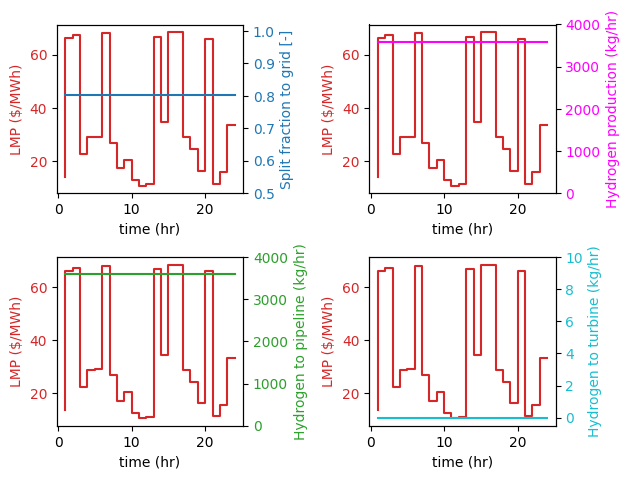

In [16]:
# Print Results
print("Optimal PEM capacity    : ", m.pem_capacity.value * 1e-3, "MW")
print("Optimal tank capacity   : ", m.tank_capacity.value * 2.016e-3, "kg")
print("Optimal turbine capacity: ", m.h2_turbine_capacity.value * 1e-6, "MW")

print("NPV :", value( m.obj ) * 1e-9, "$B")

# Using `generate_plots` we plot optimal operating conditions for a specific day
generate_plots(m, d=4, y=2022, set_time=m.set_time, lmp=m.LMP)

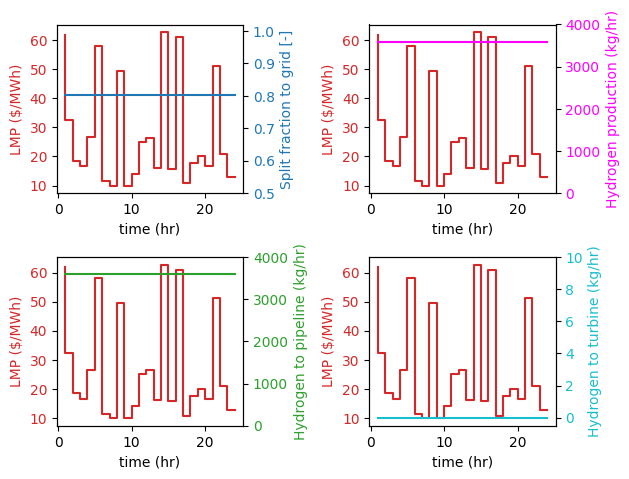

In [17]:
# Using `generate_plots` we plot optimal operating conditions for a specific day
generate_plots(m, d=8, y=2022, set_time=m.set_time, lmp=m.LMP)

In [18]:
# These optimization problems tend to be very large, so we 
# delete the model after analyzing the results to save memory.
del m

## Multiperiod Optimization Model: Stochastic

### LMP Signal

As mentioned in the previous section, due to uncertainty in various factors such as weather, demand, etc., it is not possible to determine the future locational marginal price accurately. There are many approaches to take into account the uncertainty in the LMP signal during the decision making process. One such approach involves the generation of potential LMP scenarios along with their associated probabilities and use them to formulate a stochastic program.

Here, for demonstration, we consider two different realizations of the LMP signal (i.e., two scenarios: scenario 0 and scenario 1).  These scenarios are sampled from the trained ARMA model used in the previous example.

In [19]:
# number of requested scenarios/synthetic histories
num_scenarios = 2 
set_scenarios = range(num_scenarios)

# empty dictionaries
LMP = {}
weights_days = {} 

# Gather the LMP data needed for the stochastic case
# Notation: lmp_dataset[scenario][year][cluster/day][time/hour]
for scenario in set_scenarios:
       # generate a new scenario
       synHistDict = synHistIntegration.generateSyntheticHistory("price", set_years)
       # save data to model
       LMP[scenario] = synHistDict['LMP']
       weights_days[scenario] = synHistDict['weights_days']


(14688.41 sec) Interp. Cluster ROM      : DEBUG           -> Evaluating interpolated ROM ...
(14688.41 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2018" (1 / 28)
(14688.45 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2019" (2 / 28)
(14688.46 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2020" (3 / 28)
(14688.48 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2021" (4 / 28)
(14688.51 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2022" (5 / 28)
(14688.53 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2023" (6 / 28)
(14688.55 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2024" (7 / 28)
(14688.57 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluating macro step "2025" (8 / 28)
(14688.59 sec) Interp. Cluster ROM      : DEBUG           ->  ... evaluatin

Next, we formulate an optimization problem of the form
$$ \begin{aligned}
\max_{D, D_s, u_{s, t, d}} \quad & \sum_s w_s \text{NPV}_s(D_s, u_{s, t, d})\\
& g(u_{s, t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}  \\
& h(u_{s, t, d}) \le 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}  \\
& f(u_{s, t-1, d}, u_{s, t, d}) = 0, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S} \\
& u_{s, t, d} \le D_s, & & \forall \; t \in \mathcal{T}; \; \forall \; d \in \mathcal{C}; \forall\; s \in \mathcal{S}\\
& D_s = D, & & \forall\; s \in \mathcal{S}
\end{aligned}$$

Here, the sets $\mathcal{S} = \{0, 1\}$, $\mathcal{T} = \{1, \dots, 24\}$ and $\mathcal{C} = \{1, \dots, 20\}$ denote the the set of scenarios, the set of hours in a day and the set of clusters/days in a year, respectively. $D$ denotes the design decisions (or, first-stage variables) viz. size of the PEM electrolyzer (`pem_capacity`), tank (`tank_capacity`) and the turbine (`turbine_capacity`), and $D_s$ denotes the design decisions in scenario $s$. $u_{s, t, d}$ denotes the operating decisions (or, second-stage decisions) in scenario $s$, at time $t$ of day/cluster $d$. $g(u_{s, t, d}) = 0$ and $h(u_{s, t,d}) \le 0$ denote the flowsheet model, $f(u_{s, t-1,d}, u_{s, t,d}) = 0$ connects the operating decisions at time $t-1$ and at time $t$ (e.g., tank holdup), and $u_{s, t, d} \le D_s$ ensures that the operating decision values never exceed the design capacity values (e.g., tank holdup at any time instant must not exceed the tank capacity) in scenario $s$. Finally, $D_s = D$ ensures that the design decisions are maintained the same in all scenarios (non-anticipativity constraints).

In the objective function, $w_s$ denotes the probability associated with scenario $s$, and $\text{NPV}_s$ stands for the net present value calculated in scenario $s$.

As before, we use the `MultiPeriodModel` class to formulate the stochastic multi-period optimization problem. In addition to all the arguments mentioned before, we also specify `set_scenarios`, the set of scenarios, as `[0, 1]`.

In [20]:
# Define sets
set_scenarios = list(set_scenarios)
set_years = set_years                                         # Set of years
set_days = list(LMP[0][set_years[0]].keys())                  # e.g., twenty clusters/days per year
n_time_points = len(LMP[0][set_years[0]][set_days[0]].keys()) # e.g., twenty fours in a day

# Formulate the stochastic multiperiod optimization problem
m = MultiPeriodModel(
    n_time_points=n_time_points,
    set_days=set_days,
    set_years=set_years,
    set_scenarios=set_scenarios,
    process_model_func=build_ne_flowsheet,
    initialization_func=fix_dof_and_initialize,
    unfix_dof_func=unfix_dof,
    linking_variable_func=get_linking_variable_pairs,
    flowsheet_options={"np_capacity": 1000},
    initialization_options={
        "split_frac_grid": 0.8,
        "tank_holdup_previous": 0,
        "flow_mol_to_pipeline": 10,
        "flow_mol_to_turbine": 10,
    },
    use_stochastic_build=True,
    outlvl=logging.WARNING,
)

[+   0.00] Beginning the formulation of the multiperiod optimization problem.
[+1054.37] Completed the formulation of the multiperiod optimization problem.
2023-02-03 18:05:39 [INFO] idaes.init.fs.pem.outlet_state: Property package initialization: optimal - Optimal Solution Found.
[+   8.44] Created an instance of the flowsheet and initialized it.
[+  78.87] Initialized the entire multiperiod optimization model.
[+   2.39] Unfixed the degrees of freedom from each period model.


In [21]:
# Define parameters
m.plant_life = plant_life                    # Plant lifetime: 20 years
m.tax_rate = 0.2                             # Corporate tax rate: 20%
m.discount_rate = 0.08                       # Discount rate: 8%
m.h2_demand = 1                              # Maximum amount of hydrogen that can be sold: 1 kg/s
m.LMP = LMP
m.weights_days = weights_days

# Equal probability for all scenarios
m.weights_scenarios = {s: 1/num_scenarios for s in m.set_scenarios}  

Next, add the connecting constraints and hydrogen demand constraints for each of the scenarios.

In [22]:
for s in m.set_scenarios:
    # Add first-stage variables to each scenario
    add_capacity_variables(m.scenario[s])
    
    # Set initial holdup for each day (Assumed to be zero at the beginning of each day)
    for y in m.set_years:
        for d in m.set_days:
            m.scenario[s].period[1, d, y].fs.h2_tank.tank_holdup_previous.fix(0)
    
    # Hydrogen demand constraint. 
    # Divide the RHS by the molecular mass to convert kg/s to mol/s
    obj = m.scenario[s]
    @obj.Constraint(m.set_time, m.set_days, m.set_years)
    def hydrogen_demand_constraint(blk, t, d, y):
        return blk.period[t, d, y].fs.h2_tank.outlet_to_pipeline.flow_mol[0] <= m.h2_demand / MW_H2

In [23]:
tealSettings = build_econ_settings(
    components,
    life=m.plant_life,
    dr=m.discount_rate,
    tax=m.tax_rate,
    metrics=['NPV'],
)

metrics_list = []
for s in m.set_scenarios:
    # Append cash flow expressions
    tealComponentList = []
    for name, comp in components.items():
        tealComp = build_TEAL_Component(name, comp, m, m.scenario[s], s)
        tealComponentList.append(tealComp)

    metrics = calculate_TEAL_metrics(tealSettings, tealComponentList)
    metrics_list.append(metrics)

Proposed amortization schedule cannot be longer than intended project life.
Returning a shortened schedule: 3 yrs
DEBUGG amortizing cf: Cap
DEBUGG amort alpha: [ 0.      0.3333  0.4445  0.1481  0.0741  0.    ]
DEBUGG depre alpha: [ 0. -1. -1. -1. -1.  0.]


AttributeError: '_BlockData' object has no attribute 'set_period'

In [22]:
# Add non-anticipativity constraints
m.pem_capacity = Var(within=NonNegativeReals,
                     doc="Design PEM capacity (in kW)")
m.tank_capacity = Var(within=NonNegativeReals,
                      doc="Design tank capacity (in mol)")
m.h2_turbine_capacity = Var(within=NonNegativeReals,
                            doc="Design turbine capacity (in W)")

@m.Constraint(m.set_scenarios)
def non_anticipativity_pem(blk, s):
    return blk.pem_capacity == blk.scenario[s].pem_capacity

@m.Constraint(m.set_scenarios)
def non_anticipativity_tank(blk, s):
    return blk.tank_capacity == blk.scenario[s].tank_capacity

@m.Constraint(m.set_scenarios)
def non_anticipativity_turbine(blk, s):
    return blk.h2_turbine_capacity == blk.scenario[s].h2_turbine_capacity

In [23]:
# pyomo expression for full metric wtih scenario weights applied
TEALMetric = sum( m.weights_scenarios[n] * scenario['NPV'] 
                        for n, scenario in enumerate(metrics_list) )

# Define the objective function
m.obj = Objective(expr=TEALMetric, sense=maximize)

# Define the solver object. Using the default solver: IPOPT
solver = get_solver()

# Solve the optimization problem0
solver.solve(m, tee=True)

Ipopt 3.14.7: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.7, running with linear solver MUMPS 5.5.0.

Number of nonzeros in equality constraint Jacobian...:  2903812
Number of nonzeros in inequality constraint Jacobian.:    38400
Number of nonzeros in Lagrangian Hessian.............:   979200

Total number of variables............................:  1056009
                     variables with only lower bounds:   100809
                variables with lower and upper bounds:   883200
                     variables with only upper bounds:        0
Total number of equality constrain

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1060806, 'Number of variables': 1056009, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.7\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 3280.080867290497}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [24]:
# Print Results
print("Optimal PEM capacity    : ", m.pem_capacity.value * 1e-3, "MW")
print("Optimal tank capacity   : ", m.tank_capacity.value * 2.016e-3, "kg")
print("Optimal turbine capacity: ", m.h2_turbine_capacity.value * 1e-6, "MW")

Optimal PEM capacity    :  196.26160220383377 MW
Optimal tank capacity   :  0.01451578333935298 kg
Optimal turbine capacity:  9.076526259296586e-05 MW


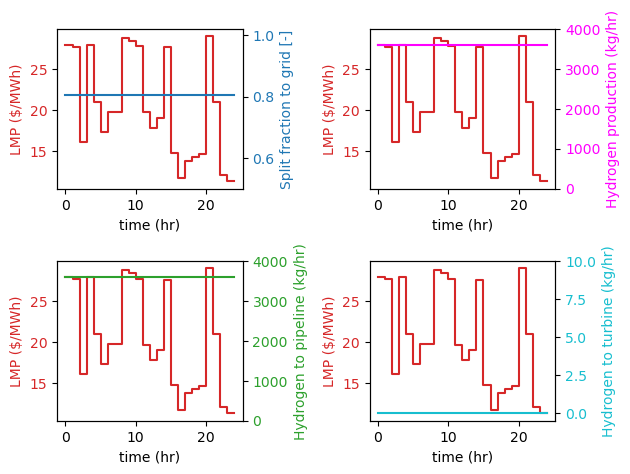

In [25]:
generate_plots(m.scenario[0], d=8, y=2022, set_time=m.set_time, lmp=m.LMP[0])